<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/Final_v1/hybrid_model/hybrid_model_(custom_cnn_%2B_vit_b32).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries



In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import pathlib

In [ ]:
import tensorflow_hub as hub

In [ ]:
import os

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!pip install vit-keras

In [ ]:
!pip install tensorflow_addons

In [ ]:
from vit_keras import vit

# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train'

In [ ]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train')

In [ ]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 7326 files belonging to 4 classes.
Using 5129 files for training.
Using 2197 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

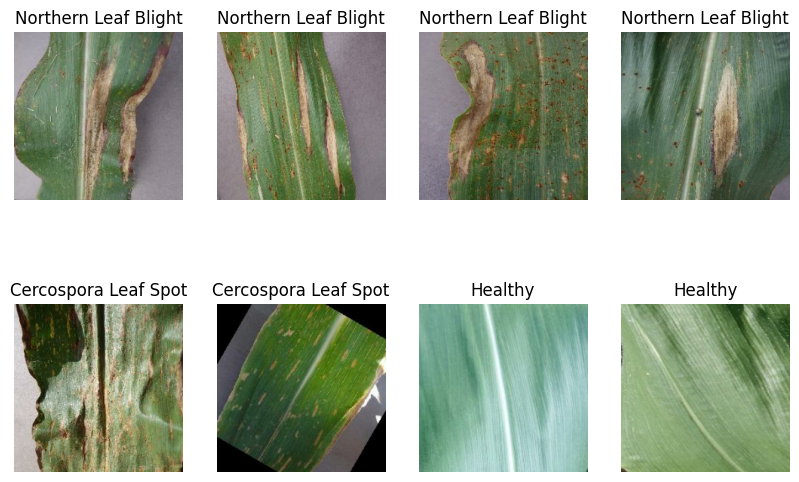

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 69


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 34


# Custom Layers

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Loading base model

The weights in this model have been obtained by training on the ILSVRC-2012-CLS dataset for image classification ("Imagenet").

In [ ]:
# Load a pre-trained ViT model without the top classification layer
vit_model = vit.vit_b32(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

353253686/353253686 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


# CNN model

In [ ]:
def create_cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = rescale(inputs)
    x = data_augmentation(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)

    return keras.Model(inputs=inputs, outputs=x)


# Hybrid model 1

In [ ]:
def create_hybrid_model_with_pretrained_vit(input_shape, num_classes, vit_feature_extractor,cnn_model):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Data augmentation and rescaling
    x = data_augmentation(inputs)
    x = rescale(x)

    # Pretrained ViT feature extractor
    vit_features = vit_feature_extractor(x)
    vit_features = layers.Flatten()(vit_features)  # Ensure it is flattened for concatenation


    # Custom CNN component
    cnn_features = cnn_model(inputs)

    # Concatenate the outputs of ViT and CNN
    combined_features = layers.Concatenate()([vit_features, cnn_features])

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(combined_features)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    hybrid_model = models.Model(inputs=inputs, outputs=outputs)
    hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    hybrid_model.summary()
    return hybrid_model

## Train hybrid model 1

In [ ]:
input_shape = (224,224,3)
num_classes = len(class_names)
epochs = 150

In [ ]:
cnn_fe = create_cnn_model(input_shape,num_classes)
vit_fe = vit_model

In [ ]:
num_classes

4

In [ ]:
hybrid_model = create_hybrid_model_with_pretrained_vit(input_shape, num_classes, vit_fe,cnn_fe)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['sequential[1][0]']          
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['rescaling[1][0]']           
                                                          2                                 

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Final_v1/hybrid_model/trained_hybrid_models'

In [ ]:
def runExperiment(train_ds, validation_ds, test_ds, input_shape, num_classes, hybrid_model, epochs):

    # Train the model
    history = hybrid_model.fit(
        train_ds,
        validation_data=validation_ds,
        verbose=1,
        epochs=epochs,
        callbacks=[early_stopping],
        batch_size=32
    )

    hybrid_model.save(os.path.join(model_path, f'hybrid_model_(custom cnn + vit_b32).keras'))

    # Evaluate the model
    test_loss, test_accuracy = hybrid_model.evaluate(test_ds)
    print(f'Test accuracy: {test_accuracy}')

    return history, test_loss, test_accuracy

In [ ]:
history, test_loss, test_accuracy = runExperiment(train_ds, validation_dataset, test_dataset, input_shape, num_classes, hybrid_model, epochs)

Epoch 1/150
161/161 [==============================] - 852s 5s/step - loss: 0.6927 - accuracy: 0.7124 - val_loss: 1.0147 - val_accuracy: 0.7421
Epoch 2/150
161/161 [==============================] - 76s 465ms/step - loss: 0.3479 - accuracy: 0.8668 - val_loss: 0.7694 - val_accuracy: 0.8061
Epoch 3/150
161/161 [==============================] - 74s 455ms/step - loss: 0.2522 - accuracy: 0.9103 - val_loss: 0.2209 - val_accuracy: 0.9261
Epoch 4/150
161/161 [==============================] - 75s 462ms/step - loss: 0.1941 - accuracy: 0.9261 - val_loss: 0.1666 - val_accuracy: 0.9369
Epoch 5/150
161/161 [==============================] - 72s 444ms/step - loss: 0.1903 - accuracy: 0.9314 - val_loss: 0.2516 - val_accuracy: 0.9125
Epoch 6/150
161/161 [==============================] - 74s 454ms/step - loss: 0.1315 - accuracy: 0.9516 - val_loss: 0.0883 - val_accuracy: 0.9675
Epoch 7/150
161/161 [==============================] - 74s 457ms/step - loss: 0.1051 - accuracy: 0.9635 - val_loss: 0.0833 - v

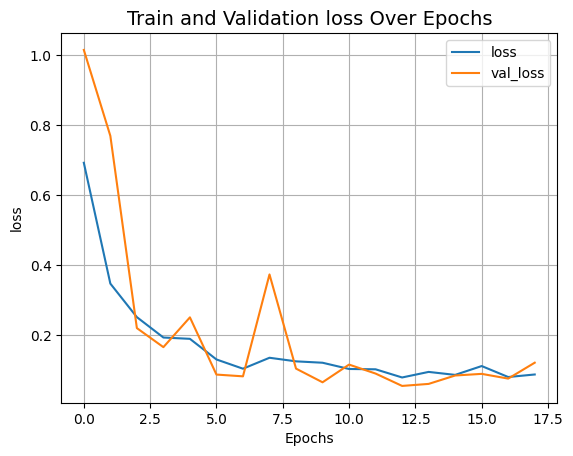

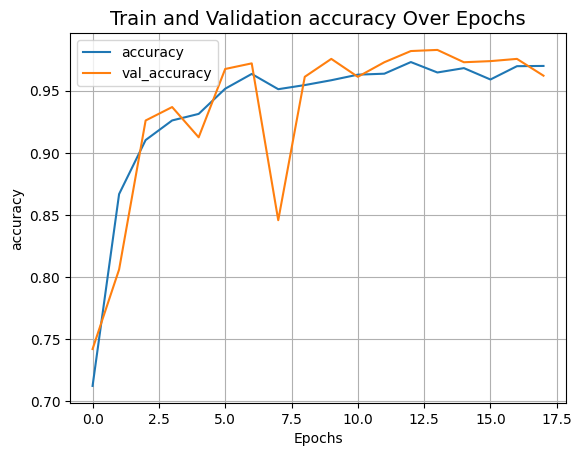

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

# Confusion matrix

In [ ]:
predictions = hybrid_model.predict(test_dataset)
predictions

34/34 [==============================] - 11s 259ms/step


array([[9.9957377e-01, 6.8546360e-05, 7.5623261e-06, 3.5015179e-04],
       [2.0557798e-06, 9.9999321e-01, 6.3188025e-07, 4.0852842e-06],
       [2.4601871e-03, 1.4888973e-06, 3.4409024e-06, 9.9753487e-01],
       ...,
       [3.4065451e-06, 8.0135857e-07, 9.9995744e-01, 3.8333106e-05],
       [8.9232689e-03, 1.4950153e-04, 2.9318026e-04, 9.9063408e-01],
       [3.2469458e-08, 9.9999976e-01, 3.3678319e-08, 1.8875086e-07]],
      dtype=float32)

In [ ]:
y_pred_classes = np.argmax(predictions, axis=1)
y_pred_classes

array([0, 1, 3, ..., 2, 3, 1])

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([0, 1, 3, ..., 2, 3, 1], dtype=int32)

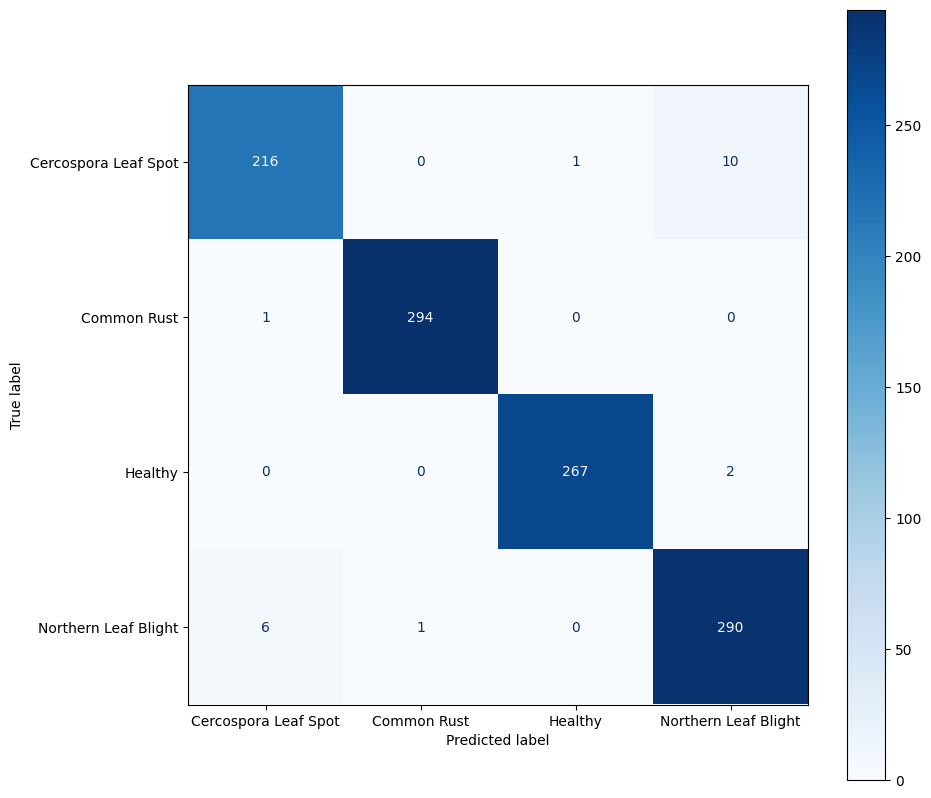

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_names))

                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.97      0.95      0.96       227
         Common Rust       1.00      1.00      1.00       295
             Healthy       1.00      0.99      0.99       269
Northern Leaf Blight       0.96      0.98      0.97       297

            accuracy                           0.98      1088
           macro avg       0.98      0.98      0.98      1088
        weighted avg       0.98      0.98      0.98      1088



# show incorrectly classified images

In [ ]:
# Find incorrectly classified images
incorrect_indices = np.where(y_pred_classes != y_true)[0]
incorrect_indices

array([ 61, 123, 133, 165, 232, 249, 256, 360, 426, 428, 470, 501, 616,
       619, 660, 731, 733, 740, 742, 877, 987])

In [ ]:
# Get the images and labels
images = np.concatenate([x for x, y in test_dataset], axis=0)
incorrect_images = images[incorrect_indices]
incorrect_true_labels = y_true[incorrect_indices]
incorrect_pred_labels = y_pred_classes[incorrect_indices]

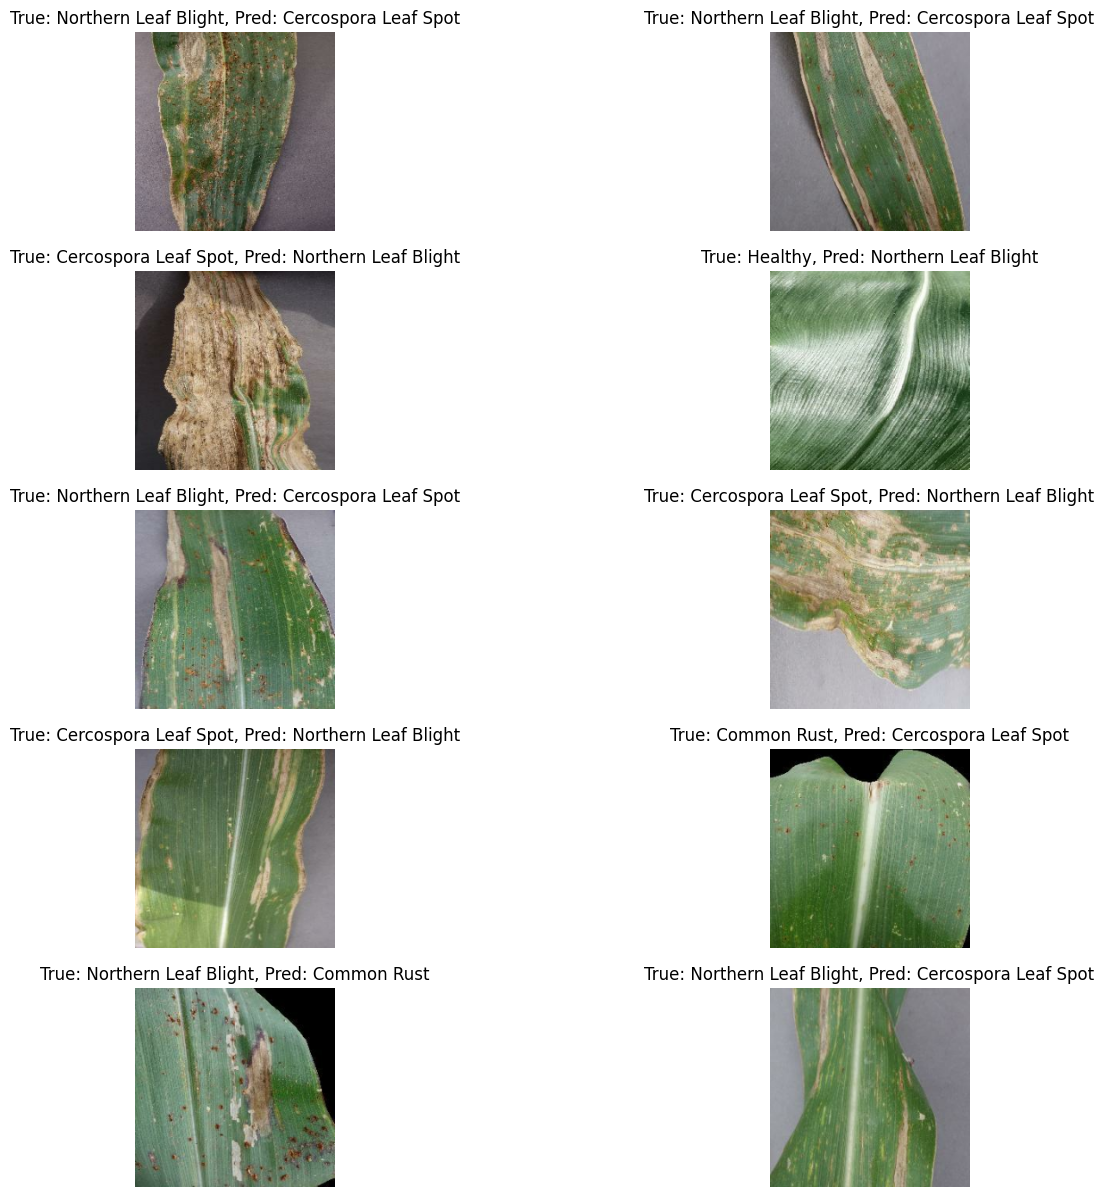

In [ ]:
# Display incorrectly classified images
num_images_to_display = 10  # Number of images to display
plt.figure(figsize=(15, 15))
for i in range(min(num_images_to_display, len(incorrect_images))):
    plt.subplot(5, 2, i + 1)
    plt.imshow(incorrect_images[i].astype("uint8"))
    plt.title(f"True: {class_names[incorrect_true_labels[i]]}, Pred: {class_names[incorrect_pred_labels[i]]}")
    plt.axis("off")
plt.show()

leaf spot : Mature lesions from gray leaf spot are rectangular, as they are restricted by the leaf veins.

leaf blight : Northern corn leaf blight is easily identified by the 1- to 6-inch cigar-shaped lesions on lower leaves, which may be grayish-green to tan in color.